# Separating the Signal from the Noise: Signal processing and feature extraction techniques for biological data
Mathias Ciliberto, Michelle Hoogenhout  
November 2022

## Objective
This notebook will demonstate a few basic time-series data visualization techniques. We'll also apply time-domain and spectral filters on real-life photoplethysmography (PPG) data to improve the signal-to-noise ratio.  

We'll test the success of the filters by comparing the estimated heart rate (calculated from the signal) to the ground truth heart rate (which was recorded using a heart rate monitor).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from numpy.lib.stride_tricks import sliding_window_view #requires numpy => 1.2
from scipy import signal
from sklearn.metrics import mean_absolute_error

## PPG-DaLiA Data Set 

We've repacked Subject 1's data from the PPG-DaLiA data set for this workshop.

In [2]:
# To get the full PPG DaLiA dataset:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00495/data.zip
# !unzip data.zip -d PPG_Dalia/

In [3]:
!wget https://github.com/michellehoog/odsc_west_sp/raw/main/data/S1.csv

--2022-11-02 18:00:42--  https://github.com/michellehoog/odsc_west_sp/raw/main/data/S1.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/michellehoog/odsc_west_sp/main/data/S1.csv [following]
--2022-11-02 18:00:43--  https://raw.githubusercontent.com/michellehoog/odsc_west_sp/main/data/S1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23530990 (22M) [text/plain]
Saving to: ‘S1.csv.2’

S1.csv.2            100%[===================>]  22.44M   146MB/s    in 0.2s    

2022-11-02 18:00:43 (146 MB/s) - ‘S1.csv.2’ saved [23530990/23530990]



In [4]:
data_df = pd.read_csv(f"./S1.csv")
data_df.head()

timestamp_ms     acc_x     acc_y     acc_z   bvp       eda   temp  \
0         0.000 -0.765625 -0.078125  0.671875  7.28  4.722437  32.13   
1        15.625       NaN       NaN       NaN  6.33       NaN    NaN   
2        31.250 -0.765625 -0.078125  0.656250  5.46       NaN    NaN   
3        46.875       NaN       NaN       NaN  4.60       NaN    NaN   
4        62.500 -0.765625 -0.078125  0.671875  3.74       NaN    NaN   

   activity  label  
0       0.0    NaN  
1       0.0    NaN  
2       0.0    NaN  
3       0.0    NaN  
4       0.0    NaN

## Data Visualization

### Visualizing the data in the time domain

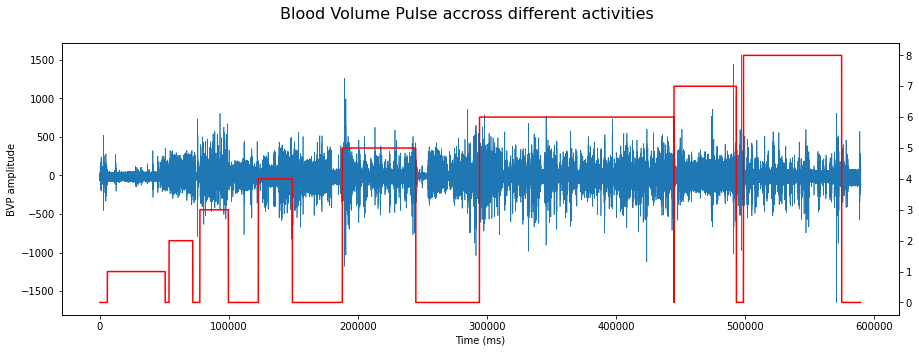

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(data_df["bvp"], linewidth=0.7)
ax.set_xlabel("Time (ms)")
ax.set_ylabel("BVP amplitude")

ax2 = ax.twinx()
ax2.plot(data_df["activity"], 'r')

fig.suptitle("Blood Volume Pulse accross different activities", fontsize = 16)
fig.show()

#TODO: add activity tick labels or text

### Visualizing the data in the time and frequency domains

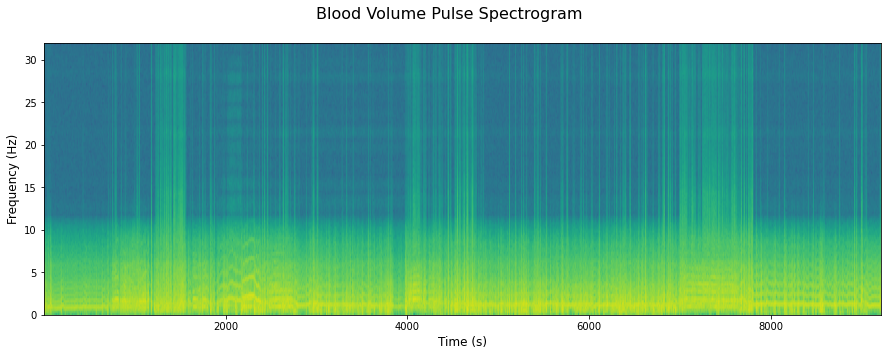

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.specgram(data_df["bvp"], Fs=64)
ax.set_xlabel("Time (s)", fontsize = 12)
ax.set_ylabel("Frequency (Hz)", fontsize = 12)

fig.suptitle("Blood Volume Pulse Spectrogram", fontsize = 16)
fig.show()

## Comparing heart rate estimation during two different activities: Sitting and Walking

We'll compare the PPG signal during a low-noise activity (sitting) and a relatively high-noise activity (walking).

### Sitting

In [7]:
# data while sitting
sitting_df = data_df[data_df.activity == 1]

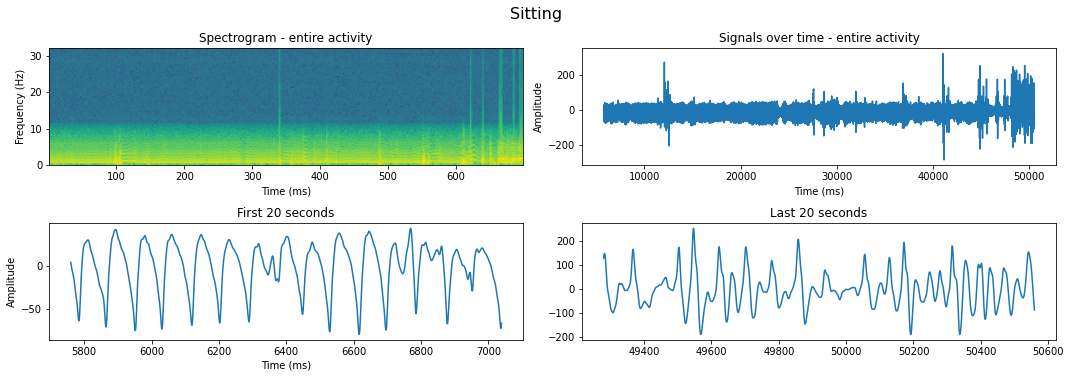

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(15, 5))
axs = axs.flatten()

axs[0].specgram(sitting_df.bvp, Fs=64)
axs[0].set_title("Spectrogram - entire activity")
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Frequency (Hz)")

axs[1].plot(sitting_df.bvp)
axs[1].set_title("Signals over time - entire activity")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("Amplitude")


axs[2].plot(sitting_df.bvp[:64*20])
axs[2].set_title("First 20 seconds")
axs[2].set_xlabel("Time (ms)")
axs[2].set_ylabel("Amplitude")


axs[3].plot(sitting_df.bvp[-64*20:])
axs[3].set_title("Last 20 seconds")


fig.suptitle("Sitting", y = 1.04, fontsize = 16)
fig.tight_layout()
plt.show()


### Walking

In [9]:
walking_df = data_df.loc[data_df.activity == 7]
walking_df.shape

(48256, 9)

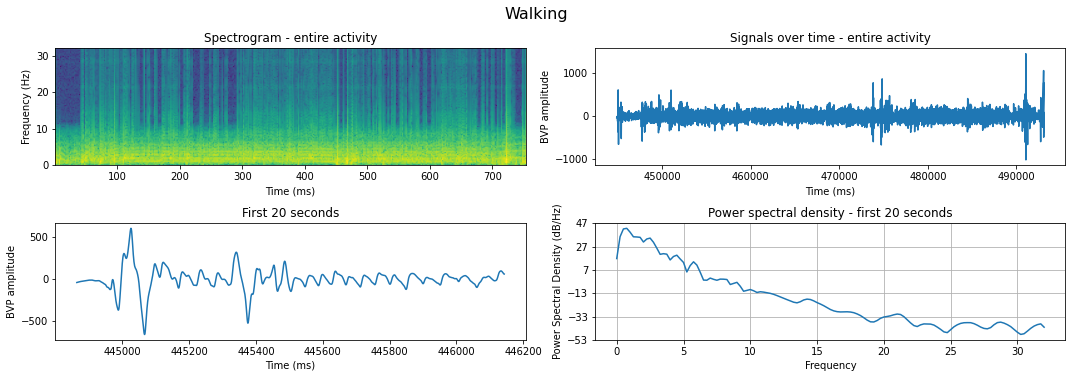

In [10]:
fig, axs = plt.subplots(2,2,figsize = (15,5))
axs = axs.flatten()

axs[0].specgram(walking_df.bvp, Fs=64)
axs[0].set_title("Spectrogram - entire activity")
axs[0].set_xlabel("Time (ms)")
axs[0].set_ylabel("Frequency (Hz)")

axs[1].plot(walking_df.bvp)
axs[1].set_title("Signals over time - entire activity")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylabel("BVP amplitude")


axs[2].plot(walking_df.bvp[:64*20])
axs[2].set_title("First 20 seconds")
axs[2].set_xlabel("Time (ms)")
axs[2].set_ylabel("BVP amplitude")


axs[3].psd(walking_df.bvp[:64*20], Fs = 64, sides = 'onesided')
axs[3].set_title("Power spectral density - first 20 seconds")

fig.suptitle("Walking", y = 1.04, fontsize = 16)
fig.tight_layout()
fig.show()

### Auto-correlation

Calculating the autocorrelation is another way of identifying how much noise there is in the signal. In a signal where observations are strongly linked to previously observations (e.g. a strong trend or stationary frequency) there is high auto-correlation.
 

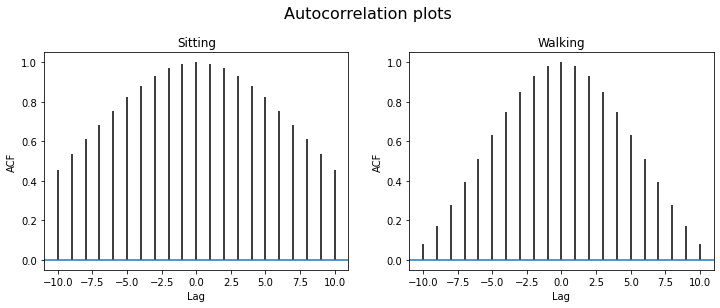

In [11]:
fig, axs = plt.subplots(1, 2, figsize = (12, 4))
axs[0].acorr(sitting_df.bvp)
axs[0].set_title("Sitting")

axs[1].acorr(walking_df.bvp);
axs[1].set_title("Walking")

for ix, ax in enumerate(axs):
  ax.set_xlabel("Lag")
  ax.set_ylabel("ACF")

fig.suptitle("Autocorrelation plots", fontsize = 16, y = 1.04);

As expected, there is a strong auto-correlation in both signals. However, the correlation between signals further away in time is lower for walking than for sitting.

A random signal (white noise) has no auto-correlation.

### Find peaks & calculate heart rate (HR) on windowed signal

`scipy.signal` has a method that identifies the peaks in periodic signals. We'll use a count of the peaks to calculate heart rate.

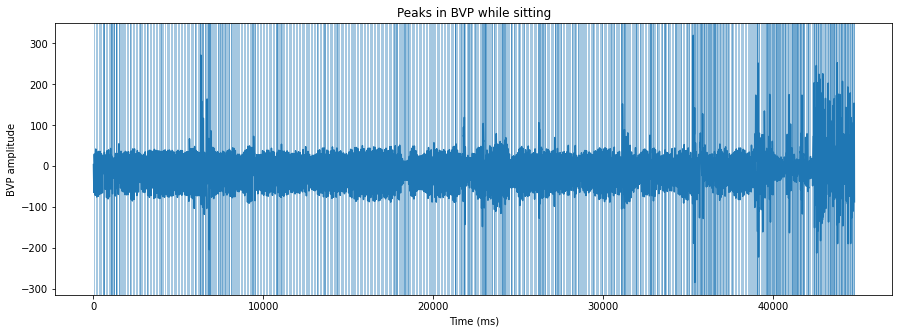

In [12]:
sitting_peaks, _ = signal.find_peaks(sitting_df.bvp)

fig, ax = plt.subplots(1, figsize = (15, 5))
ax.plot(np.array(sitting_df.bvp))
ax.set_xlabel("Time (ms)")
ax.set_ylabel("BVP amplitude")
ax.set_title("Peaks in BVP while sitting")

for p in sitting_peaks:
  ax.axvline(p, linewidth = 0.5, alpha = 0.8)


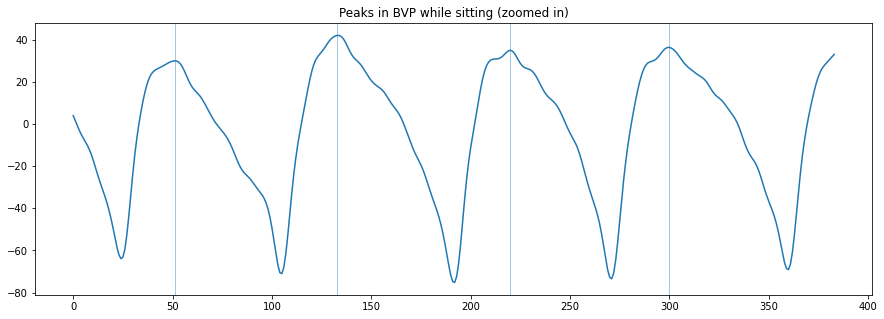

In [13]:
sitting_peaks_small, _ = signal.find_peaks(sitting_df.bvp[:64*6])
fig, ax = plt.subplots(1, figsize = (15, 5))
ax.plot(np.array(sitting_df.bvp[:64*6]))
for p in sitting_peaks_small:
  ax.axvline(p, linewidth = 0.5, alpha = 0.8)
  ax.set_title("Peaks in BVP while sitting (zoomed in)")

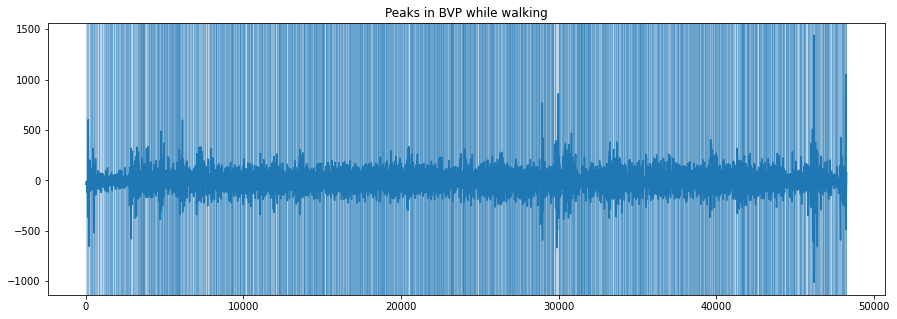

In [14]:
# takes a 1-D array and finds all local maxima by simple comparison of neighboring values
walking_bvp = np.array(walking_df.bvp)
peaks_walking, _ = signal.find_peaks(walking_bvp)

fig, ax = plt.subplots(1, figsize = (15, 5))
ax.plot(walking_bvp)
for p in peaks_walking:
  ax.axvline(p, linewidth = 0.5, alpha = 0.6)
ax.set_title("Peaks in BVP while walking");

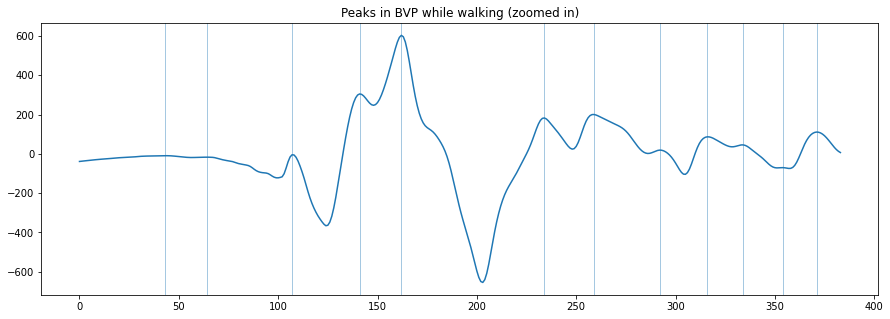

In [15]:
# examine a small section
peaks_walking_small, _ = signal.find_peaks(walking_bvp[:6*64])

fig, ax = plt.subplots(1, figsize = (15, 5))
ax.plot(walking_bvp[:6*64])
for p in peaks_walking_small:
  ax.axvline(p, linewidth = 0.5, alpha = 0.8)
ax.set_title("Peaks in BVP while walking (zoomed in)");

In [16]:
signals_per_minute = 64*60
hr_walking = len(peaks_walking)/(len(walking_bvp)/(signals_per_minute))
print(f"Walking HR: {hr_walking}")

sitting_peaks, _ = signal.find_peaks(sitting_df.bvp)
hr_sitting = len(sitting_peaks)/(len(sitting_df)/(signals_per_minute))
print(f"Sitting HR: {hr_sitting}")

Walking HR: 176.41909814323608
Sitting HR: 72.60000000000001


## Create sliding windows

Since heart rate is estimated based on an 8 second sliding window (with a two second step), we'll create 8 second sliding window from the BVP data, and calculate heart based on the number of signal peaks within that window.

Note that since heart rate is typically measured as beats per minute, we'll extrapolate heart rate from the 8 second sample to a per-minute rate.

In [17]:
#this information comes from the study readme
sampling_freq = 64
window_length_s = 8
window_shift = 2
samples_per_window = sampling_freq*window_length_s

In [18]:
#output shape is [variable, number of windows, window length (8*64)]

sliding_window_array = np.array([
    sliding_window_view(data_df.activity, samples_per_window)[::sampling_freq*window_shift, :],
    sliding_window_view(data_df.timestamp_ms, samples_per_window)[::sampling_freq*window_shift, :],
    sliding_window_view(data_df.label, samples_per_window)[::sampling_freq*window_shift, :],
    sliding_window_view(data_df.bvp, samples_per_window)[::sampling_freq*window_shift, :]
    ])

print(f"Sliding window array shape: {sliding_window_array.shape}")


sitting_mask = np.where(sliding_window_array[0] == 1)
walking_mask = np.where(sliding_window_array[0] == 7)

sitting_label_windowed = np.reshape(sliding_window_array[2][sitting_mask], (-1, 512))
sitting_bvp_windowed = np.reshape(sliding_window_array[3][sitting_mask], (-1, 512))
print(f"Sitting windows shape: {sitting_bvp_windowed.shape}")

walking_label_windowed = np.reshape(sliding_window_array[2][walking_mask], (-1, 512))
walking_bvp_windowed = np.reshape(sliding_window_array[3][walking_mask], (-1, 512))
print(f"Walking windows shape: {walking_bvp_windowed.shape}")
                

Sliding window array shape: (4, 4603, 512)
Sitting windows shape: (350, 512)
Walking windows shape: (377, 512)


## Ground Truth Heart Rate

In [19]:
# Ground truth heart rate
sitting_label = np.nanmean(sitting_label_windowed, axis = 1)
walking_label = np.nanmean(walking_label_windowed, axis = 1)

print(f"Average sitting HR: {np.mean(sitting_label)}")
print(f"Average walking HR: {np.mean(walking_label)}")

Average sitting HR: 51.262752036978
Average walking HR: 88.28186520629964


## Estimate Heart Rate from BVP

We'll estimate the subject's heart rate and compare it to the subject's known heart rate (ground truth label). Use the amount of error as an indicator of how clear the signal is.

In [20]:
def extract_heart_rate_from_bvp(windowed_array, window_length_s):
  bpm = []
  for i in range(len(windowed_array)):
    #identify peak locations
    windowed_peaks, _ = signal.find_peaks(windowed_array[i].copy())
    #extropolate beats per minute (60s) from the 8-second window
    bpm.append(len(windowed_peaks)/window_length_s*60)
  return np.array(bpm) 


In [21]:
#calculate heart rate for each 8s sliding window 
est_sitting_hr = extract_heart_rate_from_bvp(sitting_bvp_windowed, window_length_s)

print(est_sitting_hr.shape)
print(f"First 10 windows estimated HR: {est_sitting_hr[:10]}")

(350,)
First 10 windows estimated HR: [ 52.5  52.5  45.   75.   90.   75.   60.   82.5 120.  120. ]


In [22]:
est_walking_hr = extract_heart_rate_from_bvp(walking_bvp_windowed, window_length_s)
print(f"First 10 windows estimated HR: {est_walking_hr[:10]}")

First 10 windows estimated HR: [ 97.5 135.  135.  142.5 142.5 120.   97.5  90.  105.  120. ]


### MAE: Raw (unprocessed) signal

The mean absolute error is the most commonly used error metric for evaluating heart rate estimates. We'll use this metric to examine how the filters impact the accuracy of our estimates.

In [23]:
print(f"MAE sitting: {round(mean_absolute_error(sitting_label, est_sitting_hr), 2)}")
print(f"MAE walking: {round(mean_absolute_error(walking_label, est_walking_hr), 2)}")

MAE sitting: 24.59
MAE walking: 87.6


The HR estimates from BVP taken while walking (a more noisy signal) are much less accurate than the estimates while sitting. We'll use the MAE from the raw signal to compare to the MAE calculate from signals processed by different filters.

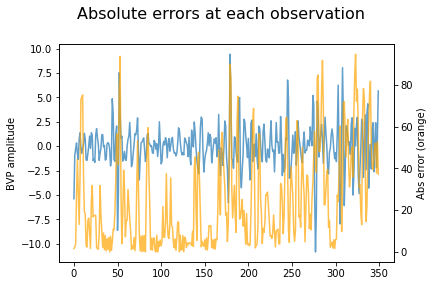

In [24]:
#to examine where our estimates fail, we can plot the absolute error in relation to the signals
sitting_absolute_error = np.abs(sitting_label-est_sitting_hr)

fig, ax = plt.subplots()
ax.plot(np.mean(sitting_bvp_windowed, axis = 1), alpha = 0.7)
ax.set_ylabel("BVP amplitude")
ax2 = ax.twinx()
ax2.plot(sitting_absolute_error, color = "orange", alpha = 0.7)
ax2.set_ylabel("Abs error (orange)")
fig.suptitle("Absolute errors at each observation", fontsize = 16, y = 1.01)
fig.show()

The graph above shows what we've already expected: Heart rate estimation errors are higher at times when the signal (shown in blue) is more noisy.


In [25]:
## Try it at yourself: Can you estimate heart rate for the Stairs activity?

## Process signals

Let's try a few filters to see how they compare. We'll apply the filter to the data recorded while sitting and walking, re-estimate heart rate from the processed signal, and compare the mean absolute error (MAE).

Reductions in the MAE mean that we are more effectively identifying signal patterns associated with heart rate.


In [45]:
# we'll use this for plotting later
def plot_filtered_signals(raw_signal, filtered_signal, title="Data", filter_label="filtered signal"):
  fig = plt.figure(figsize=(20, 12))
  gs = fig.add_gridspec(2, 3)

  fig.suptitle(title, fontsize = 16, y = 1.04)

  axs = list()
  axs.append(fig.add_subplot(gs[0, 0]))
  axs.append(fig.add_subplot(gs[1, 0]))
  axs.append(fig.add_subplot(gs[0, 1:]))
  axs.append(fig.add_subplot(gs[1, 1]))
  axs.append(fig.add_subplot(gs[1, 2]))

  axs[0].specgram(raw_signal, Fs = 64)
  axs[0].set_title("Spectrogram - entire activity (before)")
  axs[0].set_xlabel("Time (ms)")
  axs[0].set_ylabel("Frequency (Hz)")

  axs[1].specgram(filtered_signal, Fs = 64)
  axs[1].set_title("Spectrogram - entire activity (after)")
  axs[1].set_xlabel("Time (ms)")
  axs[1].set_ylabel("Frequency (Hz)")

  axs[2].plot(filtered_signal, label = filter_label)
  axs[2].plot(raw_signal, color = "r", alpha = 0.4, label = "raw")
  axs[2].set_title("Signal over time - entire activity")
  axs[2].set_xlabel("Time (ms)")
  axs[2].set_ylabel("BVP amplitude")
  axs[2].legend()


  axs[3].plot(filtered_signal[:64*20], label = filter_label)
  axs[3].plot(raw_signal[:64*20], color = "r", alpha = 0.4, label = "raw")
  axs[3].set_title("Signal over time - first 20 seconds")
  axs[3].set_xlabel("Time (ms)")
  axs[3].set_ylabel("BVP amplitude")
  axs[3].legend()

  axs[4].plot(filtered_signal[-64*20:], label = filter_label)
  axs[4].plot(raw_signal[:64*20], color = "r", alpha = 0.4, label = "raw")
  axs[4].set_title("Signal over time - last 20 seconds")
  axs[4].set_xlabel("Time (ms)")
  axs[4].set_ylabel("BVP amplitude")
  axs[4].legend()

  fig.tight_layout()
  fig.show()

### Time-domain filtering

#### Moving average
This filter is good for smoothing (averaging) the data over a certian period of time (window). it removes sudden (high frequency) changes to make the overall trend more apparent. Use it if trends (shifts from baseline) are what you are interested in.

In [27]:
# using a low-pass MA specific to the expected heart rate: freq*60/BPM
sitting_ma = sitting_df.bvp.rolling(window = (round(64*60/51)), center = True).mean()

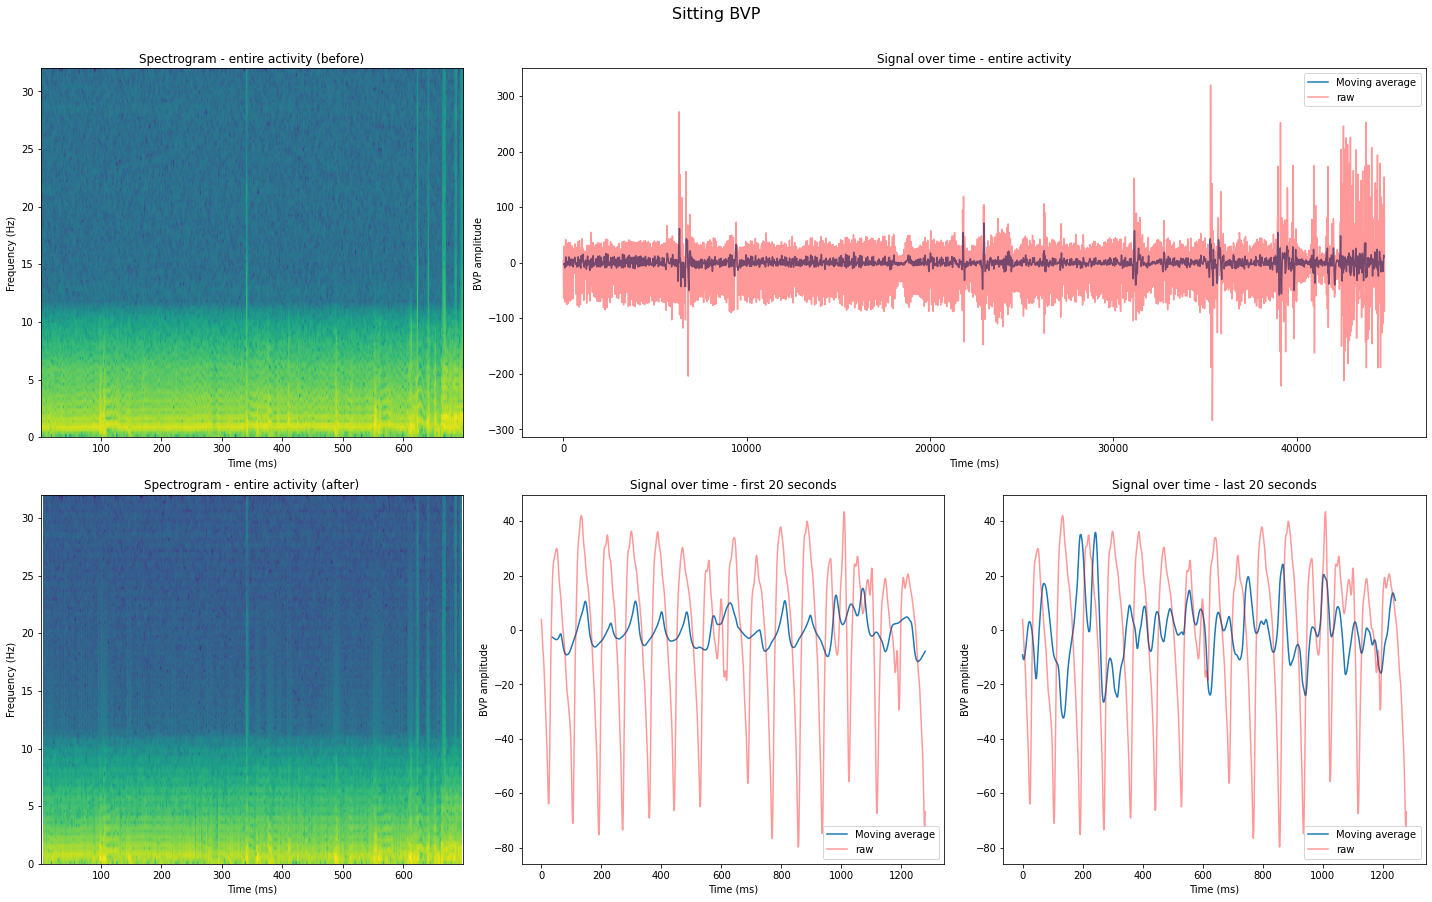

In [46]:
plot_filtered_signals(sitting_df.bvp.values, sitting_ma.values, "Sitting BVP", "Moving average")

In [47]:
walking_ma = walking_df.bvp.rolling(window = (round(64*60/81))).mean()

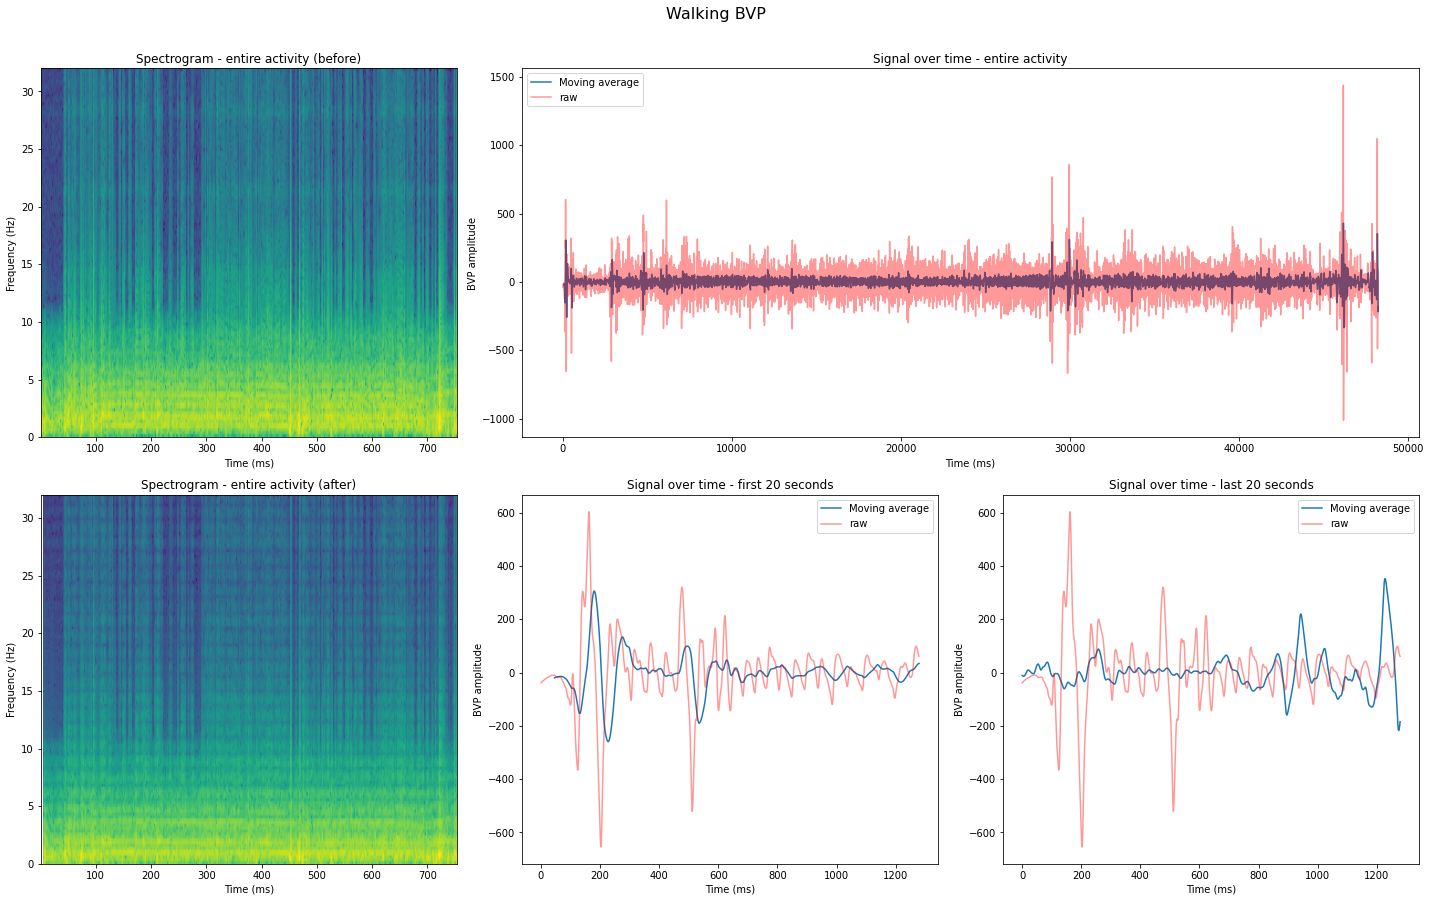

In [48]:
plot_filtered_signals(walking_df.bvp.values, walking_ma.values, "Walking BVP", "Moving average")

In [49]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [50]:
window_sitting = round(64*60/51)
window_walking = round(64*60/81)

sitting_bvp_ma_windowed = np.apply_along_axis(moving_average, 1, sitting_bvp_windowed, w = window_sitting)
walking_bvp_ma_windowed = np.apply_along_axis(moving_average, 1, walking_bvp_windowed, w = window_walking)

est_sitting_hr_ma = extract_heart_rate_from_bvp(sitting_bvp_ma_windowed, window_length_s)
est_walking_hr_ma = extract_heart_rate_from_bvp(walking_bvp_ma_windowed, window_length_s)

print(f"MAE sitting: {round(mean_absolute_error(sitting_label, est_sitting_hr_ma), 2)}")
print(f"MAE walking: {round(mean_absolute_error(walking_label, est_walking_hr_ma), 2)}")

MAE sitting: 9.27
MAE walking: 21.47


In [54]:
## Try at home: Can you apply a moving average filter with a 2 second window length on the data?

#### Savitzky-Golay Filter

Another convolution-based smoothing filter. It applies a polynomial filter to a moving window. The window size must be an odd number.

In [33]:
walking_bvp_sg = signal.savgol_filter(walking_df.bvp, window_length = 64*2+1, polyorder = 3)

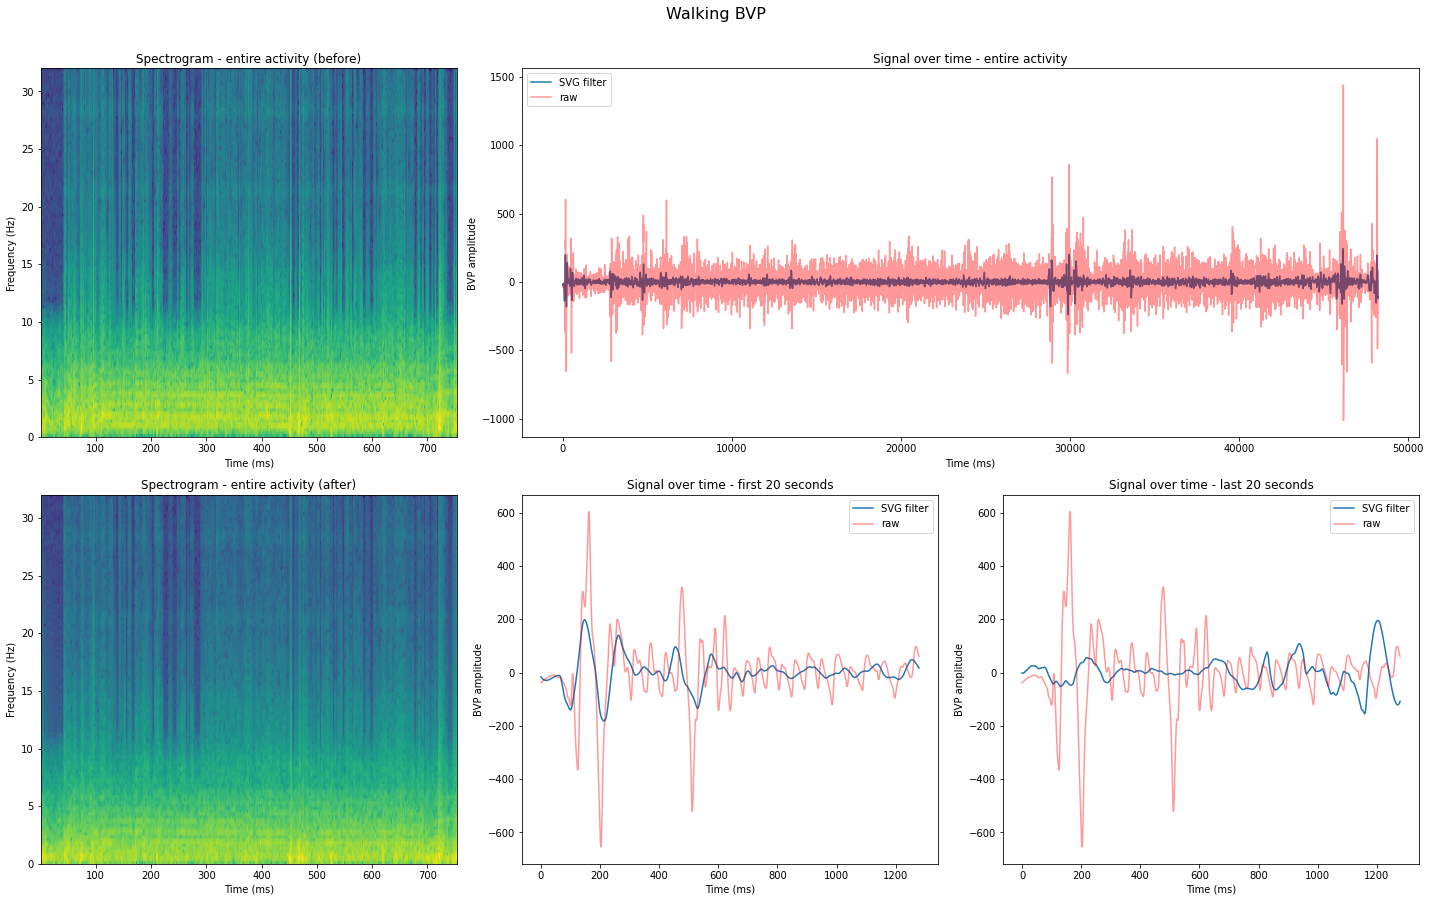

In [52]:
plot_filtered_signals(walking_df.bvp.values, walking_bvp_sg, "Walking BVP", "SVG filter")

In [35]:
sitting_bvp_sg_windowed = np.apply_along_axis(signal.savgol_filter, 1, sitting_bvp_windowed, window_length = 129, polyorder = 5)
walking_bvp_sg_windowed = np.apply_along_axis(signal.savgol_filter, 1, walking_bvp_windowed, window_length = 129, polyorder = 5)

In [36]:
est_sitting_hr_sg = extract_heart_rate_from_bvp(sitting_bvp_sg_windowed, window_length_s)
est_walking_hr_sg = extract_heart_rate_from_bvp(walking_bvp_sg_windowed, window_length_s)

print(f"MAE sitting: {round(mean_absolute_error(sitting_label, est_sitting_hr_sg), 2)}")
print(f"MAE walking: {round(mean_absolute_error(walking_label, est_walking_hr_ma), 2)}")

MAE sitting: 4.98
MAE walking: 21.47


### Spectral filtering

Let's try two frequency domain filters: high and low pass filters. Low pass filters allow all frequencies below a certain threshold, while high pass filters allow all frequencies above a certain threshold.



#### High-pass filter

In [37]:
#typical high-pass Butterworth filter for PPG is a 4th order filter with threshold between 0.05 and 0.5 
sos = signal.butter(4, Wn = 0.5, btype='high', analog=False, output='sos', fs=64)
sitting_bvp_highpass_filtered = signal.sosfilt(sos, sitting_df.bvp)

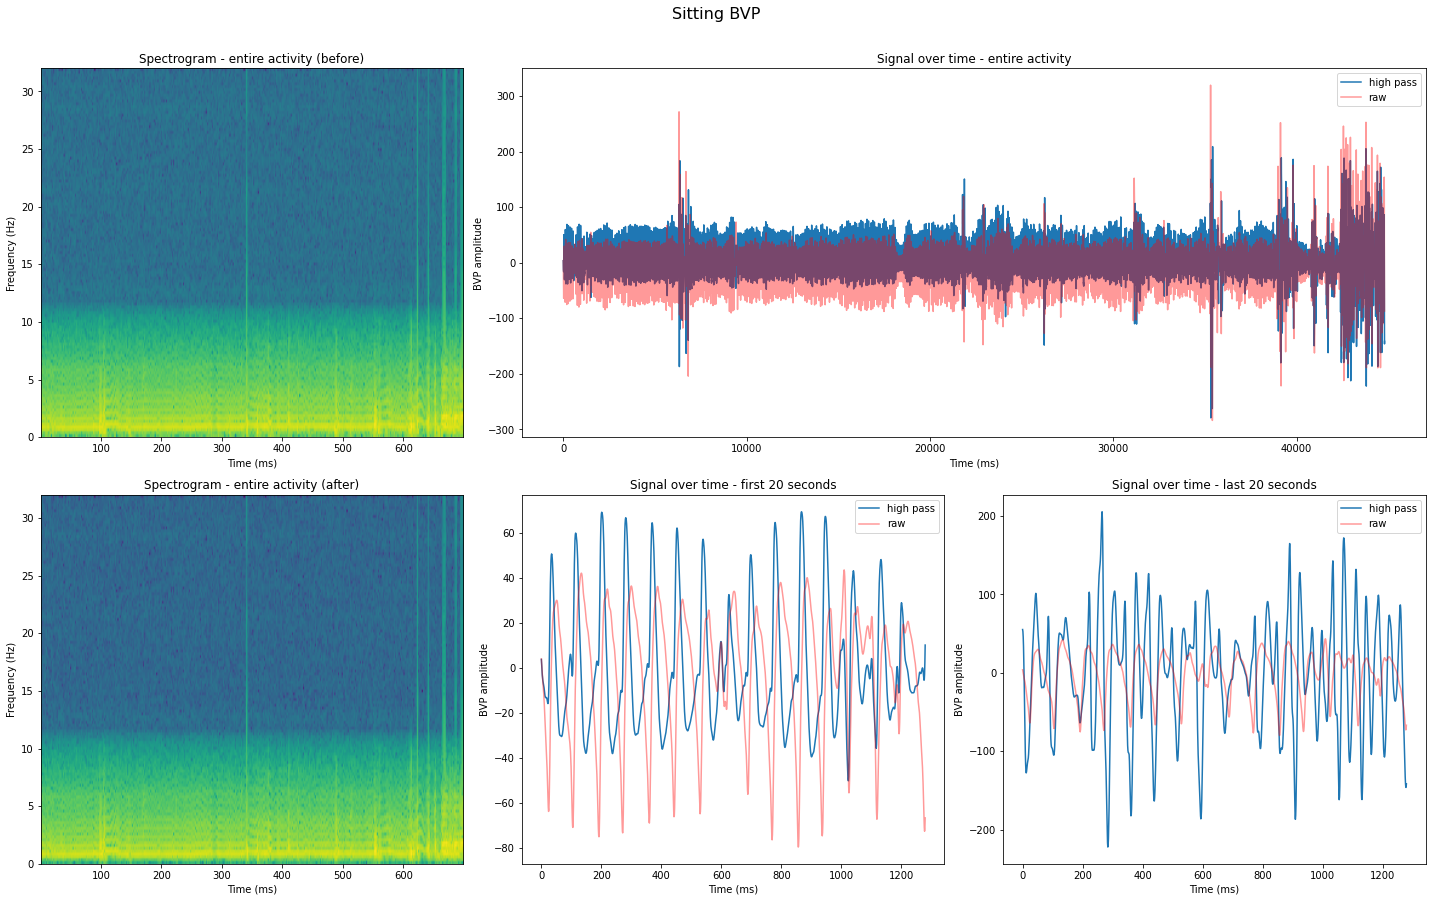

In [51]:
plot_filtered_signals(sitting_df.bvp.values, sitting_bvp_highpass_filtered, "Sitting BVP", "high pass")

In [39]:
sitting_bvp_highpass_filtered_windowed = signal.sosfilt(sos, sitting_bvp_windowed)
walking_bvp_highpass_filtered_windowed = signal.sosfilt(sos, walking_bvp_windowed)

In [40]:
est_sitting_hr_highpass = extract_heart_rate_from_bvp(sitting_bvp_highpass_filtered_windowed, window_length_s)
est_walking_hr_highpass = extract_heart_rate_from_bvp(walking_bvp_highpass_filtered_windowed, window_length_s)

print(f"MAE sitting: {round(mean_absolute_error(sitting_label, est_sitting_hr_highpass), 2)}")
print(f"MAE walking: {round(mean_absolute_error(walking_label, est_walking_hr_highpass), 2)}")

MAE sitting: 74.48
MAE walking: 84.97


#### Low pass filter

In [41]:
# HR frequency for sitting and walking is roughly 1-2 beats per second, so we'll set our low pass threshold to 2Hz
sos_low = signal.butter(4, Wn = 2, btype='low', analog=False, output='sos', fs=64)
sitting_bvp_lowpass_filtered = signal.sosfilt(sos_low, sitting_df.bvp)

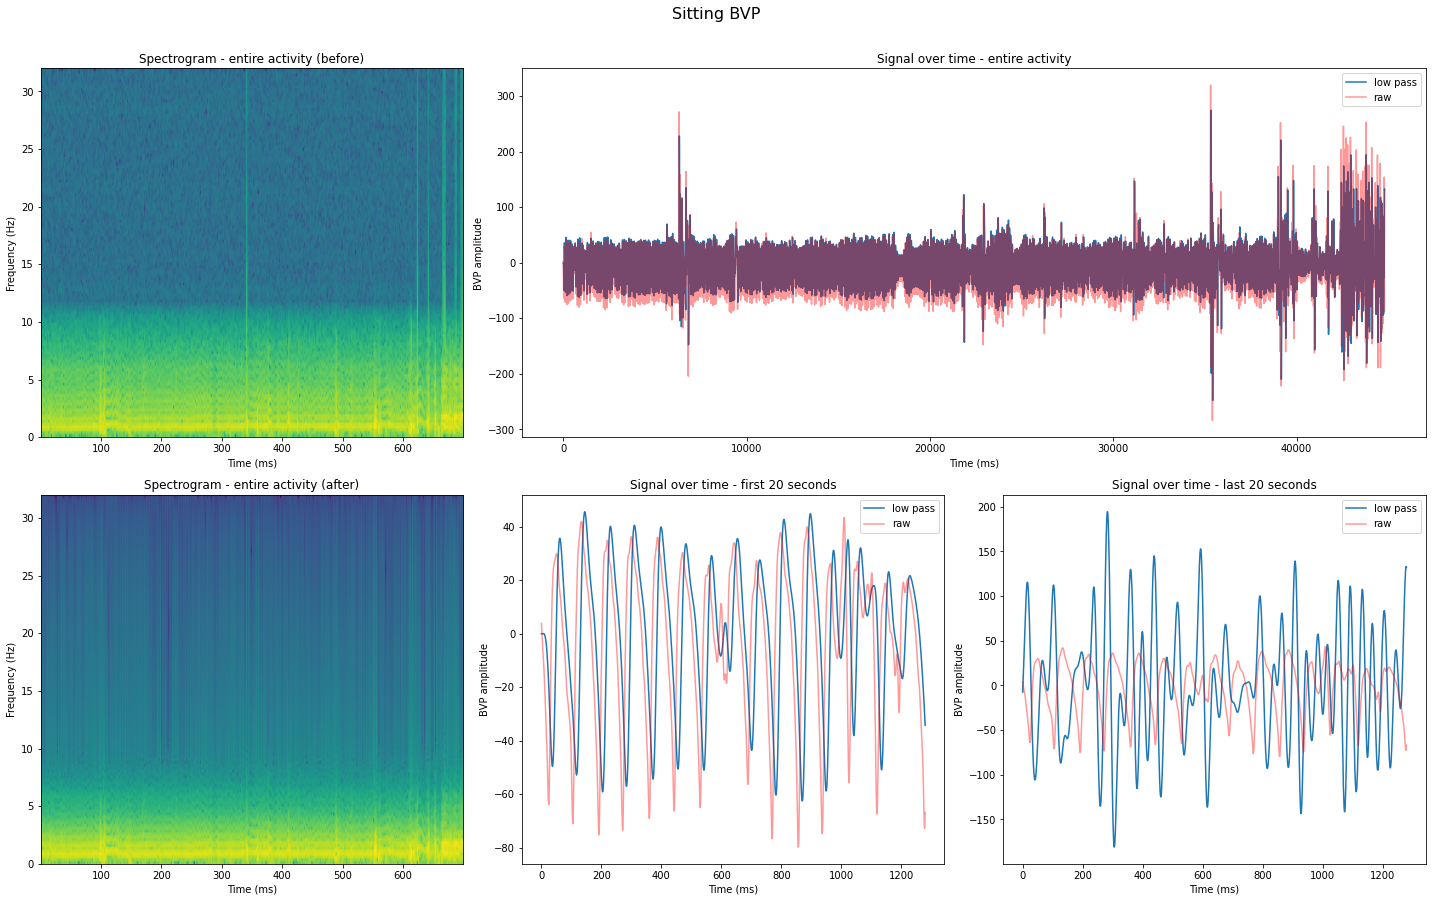

In [53]:
plot_filtered_signals(sitting_df.bvp.values, sitting_bvp_lowpass_filtered, "Sitting BVP", "low pass")

In [43]:
sitting_bvp_lowpass_filtered_windowed = signal.sosfilt(sos_low, sitting_bvp_windowed)
walking_bvp_lowpass_filtered_windowed = signal.sosfilt(sos_low, walking_bvp_windowed)

In [44]:
est_sitting_hr_lowpass = extract_heart_rate_from_bvp(sitting_bvp_lowpass_filtered_windowed, window_length_s)
est_walking_hr_lowpass = extract_heart_rate_from_bvp(walking_bvp_lowpass_filtered_windowed, window_length_s)

print(f"MAE sitting: {round(mean_absolute_error(sitting_label, est_sitting_hr_lowpass), 2)}")
print(f"MAE walking: {round(mean_absolute_error(walking_label, est_walking_hr_lowpass), 2)}")

MAE sitting: 7.86
MAE walking: 11.81


Not bad! The MAEs for both conditions are low.

In [55]:
# Try it at home: Change the low pass filter above to a second-order band pass filter.

## Conclusion

- In this example, the low-pass filter worked best accross different activities. For example, we can reduce the mean absolute error from 24 to 8 BPM for sitting data, and from 88 to 12 BPM (low pass filter).
- We can see that some filters work better than others for noisy data.
- The type of filter(s) you choose will depend on your context (Do you have periodic signals, or a slow change over time? What are your sources of noise?)
- There are many other filters (and better ones) available for improving this type of signal. There are also different ways of calculating heart rate from BVP - this notebook is just an introduction to the topic!